# Tech Career Growth & Recommendation Forecaster — Model Training & Baselines

## Notebook Overview
This notebook trains and compares baseline models for predicting **tech job trends** (e.g., wage or growth) using preprocessed datasets from the BLS, WEF, and Kaggle sources.

---

## Table of Contents

| Index | Section | Description |
|:--|:--|:--|
| **0** | **Setup & Configuration** | Load processed datasets, set random seeds, confirm schema alignment. |
| **1** | **Feature Manifest & Leakage Guard** | Enforce feature schema from manifest and validate target column. |
| **2** | **Data Integrity Snapshot** | Run exploratory checks on distributions and scaling sanity. |
| **3** | **Baseline Models** | Establish simple reference models (Dummy, Linear) for benchmark. |
| **4** | **Candidate Models (First Pass)** | Fit ElasticNet, Random Forest, and Gradient Boosting with defaults. |
| **5** | **Error Analysis & Diagnostics** | Review residuals, error distributions, and slice-level performance. |
| **6** | **Light Hyperparameter Tuning** | Randomized search with cross-validation for model refinement. |
| **7** | **Model Interpretability** | Explore feature importance and SHAP/coefficients. |
| **8** | **Final Model Selection** | Compare results, pick the best performing model. |
| **9** | **Artifacts & Outputs** | Save trained models, metrics, and predictions. |
| **10** | **Classification Model Card** | EmergingRole (yes/no). |



## Section 0 — Setup & Configuration
*(Begin below — sets seeds, loads files, and validates shapes.)*


In [33]:
# SECTION 0 — Notebook setup & run config
# Purpose: lock seeds, show versions, define file paths, load processed datasets,
# and run initial checks (shapes, column alignment, NA flags).

import os
import sys
import json
import platform
from pathlib import Path

import numpy as np
import pandas as pd

# ---- Reproducibility
SEED = 42
np.random.seed(SEED)

# ---- Environment / versions
print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Platform:", platform.platform())

# ---- File paths (adjust if needed)
DATA_DIR = Path("data/step2")  # change if your files live elsewhere

PATHS = {
    "X_train": DATA_DIR / "X_train_scaled.csv",
    "X_test": DATA_DIR / "X_test_scaled.csv",
    "y_train": DATA_DIR / "y_train.csv",
    "y_test": DATA_DIR / "y_test.csv",
    "scaler": DATA_DIR / "standard_scaler.pkl",
    "manifest": DATA_DIR / "features_manifest.json",
}

# ---- Existence checks
missing = [k for k, p in PATHS.items() if not p.exists()]
if missing:
    raise FileNotFoundError(f"Missing files: {missing}")

print("\nAll expected files are present")
for k, p in PATHS.items():
    print(f"{k}: {p}")

# ---- Load data
X_train = pd.read_csv(PATHS["X_train"])
X_test = pd.read_csv(PATHS["X_test"])
y_train = pd.read_csv(PATHS["y_train"])
y_test = pd.read_csv(PATHS["y_test"])

# ---- Basic shape checks
print("\nShapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

# ---- Column alignment between train/test
xtrain_cols = list(X_train.columns)
xtest_cols = list(X_test.columns)

same_cols = (xtrain_cols == xtest_cols)
print("\nFeature columns aligned between X_train and X_test:", "YES" if same_cols else "NO")

if not same_cols:
    train_only = [c for c in xtrain_cols if c not in xtest_cols]
    test_only = [c for c in xtest_cols if c not in xtrain_cols]
    print("\nColumns only in X_train:", train_only[:20], "..." if len(train_only) > 20 else "")
    print("Columns only in X_test :", test_only[:20], "..." if len(test_only) > 20 else "")

# ---- y columns introspection
print("\ny_train columns:", list(y_train.columns))
print("y_test columns :", list(y_test.columns))

# ---- Quick NA checks
na_summary = {
    "X_train_na_any": X_train.isna().any().any(),
    "X_test_na_any": X_test.isna().any().any(),
    "y_train_na_any": y_train.isna().any().any(),
    "y_test_na_any": y_test.isna().any().any(),
}
print("\nAny NA present?")
for k, v in na_summary.items():
    print(f"{k}: {v}")

# ---- Load feature manifest (for reference, and later safeguards)
with open(PATHS["manifest"], "r") as f:
    manifest = json.load(f)

print("\nManifest keys:", list(manifest.keys()))
print("Target (from manifest):", manifest.get("target"))

# ---- Quick preview (first 3 rows) to visually confirm structure
print("\nX_train head:")
print(X_train.head(3).to_string(index=False))

print("\ny_train head:")
print(y_train.head(3).to_string(index=False))

Python: 3.12.2
Pandas: 2.2.2
NumPy: 1.26.4
Platform: macOS-15.6-arm64-arm-64bit

All expected files are present
X_train: data/step2/X_train_scaled.csv
X_test: data/step2/X_test_scaled.csv
y_train: data/step2/y_train.csv
y_test: data/step2/y_test.csv
scaler: data/step2/standard_scaler.pkl
manifest: data/step2/features_manifest.json

Shapes:
X_train: (17, 103)
X_test : (5, 103)
y_train: (17, 1)
y_test : (5, 1)

Feature columns aligned between X_train and X_test: YES

y_train columns: ['median_annual_wage_dollars_2024']
y_test columns : ['median_annual_wage_dollars_2024']

Any NA present?
X_train_na_any: True
X_test_na_any: True
y_train_na_any: False
y_test_na_any: False

Manifest keys: ['id_cols', 'dummy_cols', 'skill_cols', 'num_to_scale', 'target', 'notes']
Target (from manifest): median_annual_wage_dollars_2024

X_train head:
                   job_title_norm                           bls_key                  sk_key  postings  median_salary_usd  remote_ratio_avg  _is_tech=True  _tech_

## Section 1 — Feature Manifest & Leakage Guard
Validate that features align with the manifest and ensure no future or target information leaks into predictors.


In [109]:
# Enforce the manifest feature set, drop IDs/extras, and impute any residual NaNs.

from pandas.api.types import is_numeric_dtype

# Reuse PATHS, X_train, X_test, y_train, y_test, manifest from Section 0
# If running standalone, uncomment the next two lines:
# DATA_DIR = Path("data/step2")
# manifest = json.loads(Path(DATA_DIR / "features_manifest.json").read_text())

# ---- Assemble the allowed feature set from the manifest
id_cols      = set(manifest.get("id_cols", []))
dummy_cols   = set(manifest.get("dummy_cols", []))
skill_cols   = set(manifest.get("skill_cols", []))
num_to_scale = set(manifest.get("num_to_scale", []))
target_name  = manifest.get("target")

allowed_features = (dummy_cols | skill_cols | num_to_scale)
print(f"Manifest target: {target_name}")
print(f"Manifest counts — allowed: {len(allowed_features)}, id_cols: {len(id_cols)}")

# ---- Identify current columns and what we will drop/keep
current_cols = list(X_train.columns)
keep_cols = [c for c in current_cols if (c in allowed_features)]
drop_cols = [c for c in current_cols if (c not in allowed_features)]

# Extra guard: always drop id_cols if they slipped into keep_cols
keep_cols = [c for c in keep_cols if c not in id_cols]
# Also drop common known identifiers if present (not in manifest but clearly IDs)
known_extra_ids = {"merge_key", "postings", "median_salary_usd", "remote_ratio_avg"}
drop_cols = sorted(set(drop_cols) | (set(current_cols) & known_extra_ids) | id_cols)

print(f"\nColumns BEFORE filtering: {len(current_cols)}")
print(f"Will KEEP: {len(keep_cols)}")
print(f"Will DROP: {len(drop_cols)}")
print("A few to-drop examples:", drop_cols[:10])

# ---- Apply the column filter (strict leakage guard)
X_train = X_train[keep_cols].copy()
X_test  = X_test[keep_cols].copy()

# ---- Impute residual NaNs
# Strategy:
#  - For numeric columns: fill with TRAIN median (computed on X_train)
#  - For dummy/indicator columns: also fill with 0 (dummies should be 0/1)
# We do a unified numeric-median strategy to keep it simple + consistent.
train_medians = {}
for col in X_train.columns:
    if is_numeric_dtype(X_train[col]):
        med = X_train[col].median()
        # fall back to 0 if median is NaN (e.g., an all-NaN column — should not happen but safe)
        if pd.isna(med):
            med = 0.0
        train_medians[col] = med
    else:
        # If somehow non-numeric made it through, we drop it (shouldn't happen after filtering).
        drop_cols.append(col)

# If any non-numeric slipped in, drop them now.
non_numeric_cols = [c for c in X_train.columns if not is_numeric_dtype(X_train[c])]
if non_numeric_cols:
    print("\nDropping unexpected non-numeric columns:", non_numeric_cols)
    X_train.drop(columns=non_numeric_cols, inplace=True, errors="ignore")
    X_test.drop(columns=non_numeric_cols, inplace=True, errors="ignore")

# Impute using train medians
X_train = X_train.fillna(value=train_medians)
X_test  = X_test.fillna(value=train_medians)

# ---- Final safety checks
def na_report(df, name):
    return df.isna().sum().sum(), df.shape

na_train, shape_train = na_report(X_train, "X_train")
na_test,  shape_test  = na_report(X_test,  "X_test")

print("\nAfter filtering + imputation:")
print("X_train shape:", shape_train, "| total NAs:", na_train)
print("X_test  shape:", shape_test,  "| total NAs:", na_test)

# Align columns explicitly (should already match)
X_test = X_test[X_train.columns]
assert list(X_train.columns) == list(X_test.columns), "Train/Test columns misaligned after filtering."

# ---- Persist the final feature list for traceability
feature_list_path = Path(PATHS["manifest"]).parent / "feature_list_final.json"
Path(feature_list_path).write_text(json.dumps({"features": list(X_train.columns)}, indent=2))
print(f"\nSaved final feature list to: {feature_list_path}")

# (Optional) Quick glance at kept columns
print("\nSample of kept columns:", list(X_train.columns)[:12])


Manifest target: median_annual_wage_dollars_2024
Manifest counts — allowed: 96, id_cols: 3

Columns BEFORE filtering: 96
Will KEEP: 96
Will DROP: 3
A few to-drop examples: ['bls_key', 'job_title_norm', 'sk_key']

After filtering + imputation:
X_train shape: (17, 96) | total NAs: 0
X_test  shape: (5, 96) | total NAs: 0

Saved final feature list to: data/step2/feature_list_final.json

Sample of kept columns: ['_is_tech=True', '_tech_reason=hard_include_or_must_have', '_tech_reason=soc15_default_keep', 'job_title=Actuaries', 'job_title=Computer and information research scientists', 'job_title=Computer and information systems managers', 'job_title=Computer network architects', 'job_title=Computer network support specialists', 'job_title=Computer occupations, all other', 'job_title=Computer programmers', 'job_title=Computer systems analysts', 'job_title=Computer user support specialists']


## Section 2 — Data Integrity Snapshot
Inspect feature distributions, confirm scaling ranges (~N(0,1)), and validate target variable statistics.


Target column: median_annual_wage_dollars_2024

— y_train summary —
 count      mean      std     min     p25   median      p75      max
    17 105287.06 22853.41 60340.0 96800.0 103300.0 124910.0 140910.0

— y_test summary —
 count     mean      std     min      p25   median      p75      max
     5 122174.0 31947.84 90930.0 103790.0 108970.0 135980.0 171200.0

Scaled feature check (found 9 of 9 expected):
                                     feature  mean_train  std_train  abs_mean  std_minus_1
                                       score        -0.0     1.0308       0.0       0.0308
           employment_change_percent_2023-33         0.0     1.0308       0.0       0.0308
                             employment_2033         0.0     1.0308       0.0       0.0308
                  percent_self_employed_2023        -0.0     1.0308       0.0       0.0308
        employment_distribution_percent_2023         0.0     1.0308       0.0       0.0308
           employment_change_numeric_2023-3

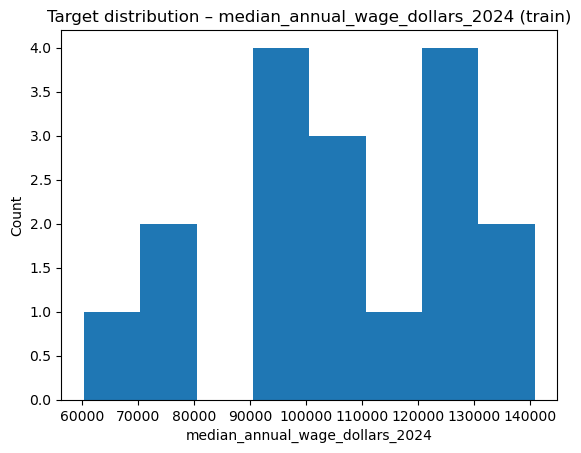

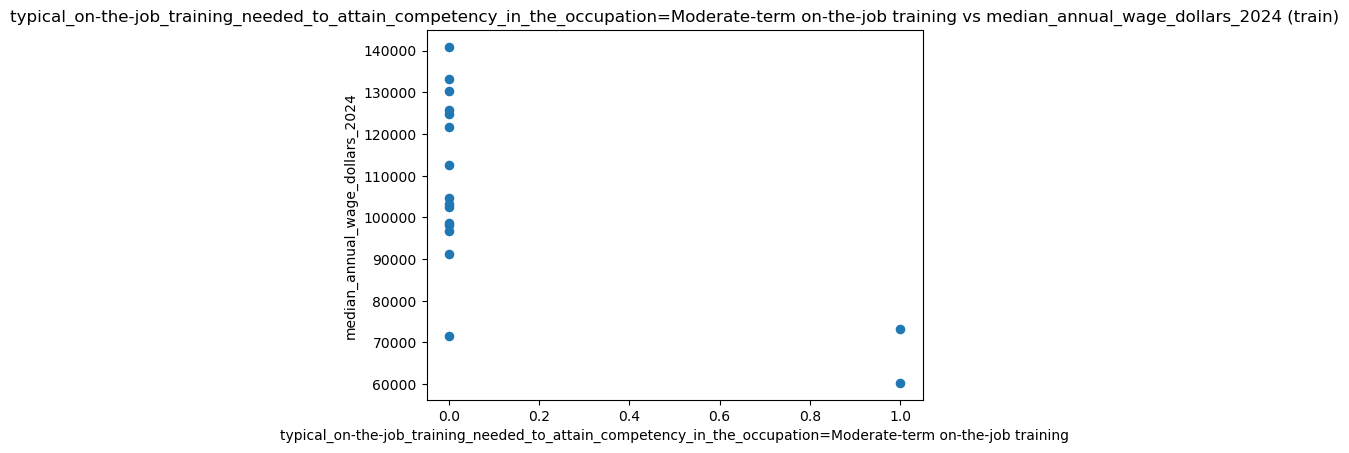


Saved: data/step2/y_train_stats.csv
Saved: data/step2/y_test_stats.csv
Saved: data/step2/scaling_check.csv
Saved: data/step2/corr_top15.csv
Saved: data/step2/section2_integrity_report.json


In [111]:
# SECTION 2 — Data Integrity Snapshot
# Goal: sanity-check target distribution, scaling, collinearity hints, and outliers.

import matplotlib.pyplot as plt

# Reuse objects from earlier cells: PATHS, manifest, X_train, X_test, y_train, y_test

OUT_DIR = Path(PATHS["manifest"]).parent  # same folder as your step2 files

# ---- 2.1 Target stats (train & test)
def describe_series(s: pd.Series) -> pd.DataFrame:
    return pd.DataFrame({
        "count": [s.count()],
        "mean": [s.mean()],
        "std": [s.std()],
        "min": [s.min()],
        "p25": [s.quantile(0.25)],
        "median": [s.median()],
        "p75": [s.quantile(0.75)],
        "max": [s.max()],
    })

target_col = y_train.columns[0]
y_train_stats = describe_series(y_train[target_col])
y_test_stats  = describe_series(y_test[target_col])

print("Target column:", target_col)
print("\n— y_train summary —")
print(y_train_stats.round(2).to_string(index=False))
print("\n— y_test summary —")
print(y_test_stats.round(2).to_string(index=False))

# ---- 2.2 Scaling sanity on numeric features the manifest says were standardized
num_to_scale = list(manifest.get("num_to_scale", []))
num_to_scale_present = [c for c in num_to_scale if c in X_train.columns]
missing_scaled = [c for c in num_to_scale if c not in X_train.columns]

scaling_check = pd.DataFrame({
    "feature": num_to_scale_present,
    "mean_train": [X_train[c].mean() for c in num_to_scale_present],
    "std_train":  [X_train[c].std(ddof=1) for c in num_to_scale_present],
})
scaling_check["abs_mean"] = scaling_check["mean_train"].abs()
scaling_check["std_minus_1"] = (scaling_check["std_train"] - 1).abs()
scaling_check_sorted = scaling_check.sort_values(["abs_mean", "std_minus_1"], ascending=[False, False])

print(f"\nScaled feature check (found {len(num_to_scale_present)} of {len(num_to_scale)} expected):")
if missing_scaled:
    print("Missing (not in X_train after filtering):", missing_scaled)
print(scaling_check_sorted.round(4).to_string(index=False))

# ---- 2.3 Duplicate rows (across final feature set)
dup_train = X_train.duplicated().sum()
dup_test  = X_test.duplicated().sum()
print(f"\nDuplicate rows — train: {dup_train}, test: {dup_test}")

# ---- 2.4 Simple outlier scan (z-score > 4 on train)
# Because features are standardized, values > |4| are suspicious.
z_outliers = (X_train.abs() > 4).sum().sort_values(ascending=False)
z_outliers = z_outliers[z_outliers > 0]
if not z_outliers.empty:
    print("\nFeatures with |z| > 4 (count of rows exceeding threshold):")
    print(z_outliers.head(15).to_string())
else:
    print("\nNo |z| > 4 outliers detected on X_train.")

# ---- 2.5 Correlation of features with target (top 15 by |corr|)
# Note: features are standardized; target is on its original scale.
# This is just a directional hint, not causation.
y_vec = y_train[target_col].astype(float).values
corrs = {}
for c in X_train.columns:
    xc = X_train[c].astype(float).values
    if np.std(xc) == 0:
        continue
    corrs[c] = np.corrcoef(xc, y_vec)[0,1]

corr_df = (
    pd.Series(corrs, name="corr_with_target")
    .to_frame()
    .assign(abs_corr=lambda d: d["corr_with_target"].abs())
    .sort_values("abs_corr", ascending=False)
    .head(15)
)
print("\nTop 15 features by |correlation with target|:")
print(corr_df.round(4).to_string())

# ---- 2.6 Plots (1 per figure, no specific colors)
# Histogram of y_train
plt.figure()
plt.hist(y_train[target_col].values, bins=8)
plt.title(f"Target distribution – {target_col} (train)")
plt.xlabel(target_col)
plt.ylabel("Count")
plt.show()

# Scatter: pick top correlated feature vs target (if any)
if not corr_df.empty:
    top_feat = corr_df.index[0]
    plt.figure()
    plt.scatter(X_train[top_feat].values, y_train[target_col].values, s=35)
    plt.title(f"{top_feat} vs {target_col} (train)")
    plt.xlabel(top_feat)
    plt.ylabel(target_col)
    plt.show()

# ---- 2.7 Persist quick snapshot artifacts
y_train_stats.to_csv(OUT_DIR / "y_train_stats.csv", index=False)
y_test_stats.to_csv(OUT_DIR / "y_test_stats.csv", index=False)
scaling_check_sorted.to_csv(OUT_DIR / "scaling_check.csv", index=False)
corr_df.to_csv(OUT_DIR / "corr_top15.csv")

integrity_report = {
    "target_col": target_col,
    "train_rows": int(X_train.shape[0]),
    "test_rows": int(X_test.shape[0]),
    "n_features": int(X_train.shape[1]),
    "dup_train": int(dup_train),
    "dup_test": int(dup_test),
    "missing_scaled_features": missing_scaled,
}
with open(OUT_DIR / "section2_integrity_report.json", "w") as f:
    json.dump(integrity_report, f, indent=2)

print(f"\nSaved: {OUT_DIR / 'y_train_stats.csv'}")
print(f"Saved: {OUT_DIR / 'y_test_stats.csv'}")
print(f"Saved: {OUT_DIR / 'scaling_check.csv'}")
print(f"Saved: {OUT_DIR / 'corr_top15.csv'}")
print(f"Saved: {OUT_DIR / 'section2_integrity_report.json'}")


## Section 3 — Baseline Models
Train and evaluate simple baselines (DummyRegressor, LinearRegression) to establish performance benchmarks.


In [115]:
# Dummy(median) and a stable linear baseline (Ridge) on the pre-scaled features.

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

# Use new API if present; fallback otherwise
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def rmse(y_true, y_pred):
        return _rmse(y_true, y_pred)
except Exception:
    from sklearn.metrics import mean_squared_error
    def rmse(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)

def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mae = mean_absolute_error(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    eps = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100.0
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MAPE%": mape, "RMSE": rmse_val, "R2": r2}

results = []
target_col = y_train.columns[0]

# --- 3.1 Dummy baseline (median)
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train[target_col])

for X, y, split in [
    (X_train, y_train[target_col], "train"),
    (X_test,  y_test[target_col],  "test"),
]:
    y_pred = dummy.predict(X)
    results.append({"model": "Dummy(median)", "split": split, **regression_metrics(y, y_pred)})

# --- 3.2 Linear baseline (Ridge) — safer than OLS with 96 features & 17 rows
ridge = Ridge(alpha=1.0, random_state=SEED)
ridge.fit(X_train, y_train[target_col])

for X, y, split in [
    (X_train, y_train[target_col], "train"),
    (X_test,  y_test[target_col],  "test"),
]:
    y_pred = ridge.predict(X)
    results.append({"model": "Ridge(alpha=1.0)", "split": split, **regression_metrics(y, y_pred)})

# --- 3.3 Results table
results_df = pd.DataFrame(results)
display(results_df)

# --- 3.4 Save test predictions for quick inspection/dash hookups
out_dir = Path(PATHS["manifest"]).parent
pd.DataFrame({
    "y_test": y_test[target_col].values,
    "Dummy_pred": dummy.predict(X_test),
    "Ridge_pred": ridge.predict(X_test),
}).to_csv(out_dir / "baseline_predictions_test.csv", index=False)
print("Saved:", out_dir / "baseline_predictions_test.csv")


,model,split,MAE,MAPE%,RMSE,R2
0,Dummy(median),train,17724.705882,18.630536,22259.933671,-0.008032
1,Dummy(median),test,23822.000000,16.594681,34245.578693,-0.436269
2,Ridge(alpha=1.0),train,2540.713578,2.696201,3065.885185,0.980878
3,Ridge(alpha=1.0),test,19747.908651,14.209371,26322.351256,0.151452


Saved: data/step2/baseline_predictions_test.csv


## Section 4 — Candidate Models (First Pass)
Fit ElasticNet, Random Forest, and Gradient Boosting models using default hyperparameters to gauge baseline performance.


In [117]:
# ElasticNet (with LOOCV), RandomForest (shallow), HistGradientBoosting (small/regularized)

from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, r2_score

# ---- RMSE helper (new sklearn API safe)
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def rmse(y_true, y_pred): return _rmse(y_true, y_pred)
except Exception:
    from sklearn.metrics import mean_squared_error
    def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mae = mean_absolute_error(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    eps = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100.0
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MAPE%": mape, "RMSE": rmse_val, "R2": r2}

# Reuse: SEED, X_train, X_test, y_train, y_test, PATHS
target_col = y_train.columns[0]
y_tr = y_train[target_col].values.ravel()
y_te = y_test[target_col].values.ravel()

def add_model_results(name, model, do_loocv=True):
    model.fit(X_train, y_tr)
    y_pred_tr = model.predict(X_train)
    y_pred_te = model.predict(X_test)
    rows = [
        {"model": name, "split": "train", **regression_metrics(y_tr, y_pred_tr)},
        {"model": name, "split": "test",  **regression_metrics(y_te, y_pred_te)},
    ]
    # LOOCV MAE as a small-sample stability check
    cv_mae = np.nan
    if do_loocv:
        try:
            loo = LeaveOneOut()
            neg_mae = cross_val_score(model, X_train, y_tr, cv=loo, scoring="neg_mean_absolute_error", n_jobs=None)
            cv_mae = float((-neg_mae).mean())
        except Exception as e:
            cv_mae = np.nan
    for r in rows:
        r["CV_LOO_MAE"] = cv_mae
    return rows, model

# Start with previous results if present
try:
    _res = results_df.to_dict("records")
except NameError:
    _res = []

# 4.1 ElasticNetCV — strong for p >> n, automatic alpha & l1_ratio
enet = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    alphas=np.logspace(-3, 2, 40),
    cv=LeaveOneOut(),       # tune with LOOCV
    max_iter=50000,
    random_state=SEED,
)
res_enet, fitted_enet = add_model_results("ElasticNetCV", enet)
_res.extend(res_enet)

# 4.2 RandomForest — shallow trees to avoid overfitting
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=2,
    random_state=SEED,
    n_jobs=-1,
)
res_rf, fitted_rf = add_model_results("RandomForest(d4_l2)", rf)
_res.extend(res_rf)

# 4.3 HistGradientBoosting — small trees + early stopping
hgb = HistGradientBoostingRegressor(
    max_depth=3,
    learning_rate=0.05,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.3,
    random_state=SEED,
)
res_hgb, fitted_hgb = add_model_results("HistGB(depth3)", hgb)
_res.extend(res_hgb)

# 4.4 Results table
results_df = pd.DataFrame(_res)
display(results_df.sort_values(["split","MAE"]).reset_index(drop=True))

# 4.5 Save coefficients / importances for quick interpretability
out_dir = Path(PATHS["manifest"]).parent

# ElasticNet coefficients (sorted)
coef_enet = pd.Series(fitted_enet.coef_, index=X_train.columns, name="coef").sort_values()
coef_enet.to_csv(out_dir / "elasticnet_coefficients.csv")

# RandomForest feature importances (top 25)
imp_rf = pd.Series(fitted_rf.feature_importances_, index=X_train.columns, name="importance").sort_values(ascending=False)
imp_rf.head(25).to_csv(out_dir / "rf_feature_importances_top25.csv")

# HistGB permutation importances (more stable than built-in on tiny n)
pi = permutation_importance(fitted_hgb, X_train, y_tr, n_repeats=50, random_state=SEED, scoring="neg_mean_absolute_error")
imp_hgb = pd.Series(pi.importances_mean, index=X_train.columns, name="perm_importance").sort_values(ascending=False)
imp_hgb.head(25).to_csv(out_dir / "hgb_perm_feature_importances_top25.csv")

print("Saved:", out_dir / "elasticnet_coefficients.csv")
print("Saved:", out_dir / "rf_feature_importances_top25.csv")
print("Saved:", out_dir / "hgb_perm_feature_importances_top25.csv")


,model,split,MAE,MAPE%,RMSE,R2,CV_LOO_MAE
0,RandomForest(d4_l2),test,18998.699833,13.620735,24745.856625,0.250051,17245.951815
1,Ridge(alpha=1.0),test,19747.908651,14.209371,26322.351256,0.151452,NaN
2,ElasticNetCV,test,23130.417233,16.260565,33057.293276,-0.338325,22193.291966
3,HistGB(depth3),test,23385.818182,17.693549,29880.268085,-0.093442,19401.871658
4,Dummy(median),test,23822.000000,16.594681,34245.578693,-0.436269,NaN
5,Ridge(alpha=1.0),train,2540.713578,2.696201,3065.885185,0.980878,NaN
6,RandomForest(d4_l2),train,8731.665976,9.244997,11153.751737,0.746914,17245.951815
7,ElasticNetCV,train,17713.053804,18.973926,21985.277899,0.016689,22193.291966
8,Dummy(median),train,17724.705882,18.630536,22259.933671,-0.008032,NaN
9,HistGB(depth3),train,19458.556150,22.116968,23622.274899,-0.135194,19401.871658


Saved: data/step2/elasticnet_coefficients.csv
Saved: data/step2/rf_feature_importances_top25.csv
Saved: data/step2/hgb_perm_feature_importances_top25.csv


In [118]:
# SECTION 4B — Leaderboard summary & provisional winner

# Reuse: results_df, fitted_enet, fitted_rf, fitted_hgb, X_train, y_train, X_test, y_test, PATHS, SEED
target_col = y_train.columns[0]
out_dir = Path(PATHS["manifest"]).parent

# --- 4B.1 Leaderboard on TEST
lb = (
    results_df[results_df["split"] == "test"]
    .sort_values(["MAE", "RMSE", "R2"], ascending=[True, True, False])
    .reset_index(drop=True)
)
display(lb)

# Choose best by MAE (tie-breaker: higher R2)
best_row = lb.iloc[0]
best_model_name = best_row["model"]
print(f"\nProvisional best model (test set): {best_model_name}")

# --- 4B.2 Quick feature view for the chosen model
if "ElasticNetCV" in best_model_name:
    coef = pd.Series(fitted_enet.coef_, index=X_train.columns, name="coef")
    top_pos = coef.sort_values(ascending=False).head(10)
    top_neg = coef.sort_values(ascending=True).head(10)
    print("\nElasticNet — top positive coefficients:")
    display(top_pos.to_frame())
    print("\nElasticNet — top negative coefficients:")
    display(top_neg.to_frame())
elif "RandomForest" in best_model_name:
    imp = pd.Series(fitted_rf.feature_importances_, index=X_train.columns, name="importance")
    print("\nRandomForest — top 15 feature importances:")
    display(imp.sort_values(ascending=False).head(15).to_frame())
elif "HistGB" in best_model_name:
    print("\nHistGradientBoosting — permutation importances (top 15):")
    pi = permutation_importance(fitted_hgb, X_train, y_train[target_col].values.ravel(),
                                n_repeats=50, random_state=SEED, scoring="neg_mean_absolute_error")
    imp = pd.Series(pi.importances_mean, index=X_train.columns, name="perm_importance")
    display(imp.sort_values(ascending=False).head(15).to_frame())
else:
    print("No matching model name — skip feature view.")


,model,split,MAE,MAPE%,RMSE,R2,CV_LOO_MAE
0,RandomForest(d4_l2),test,18998.699833,13.620735,24745.856625,0.250051,17245.951815
1,Ridge(alpha=1.0),test,19747.908651,14.209371,26322.351256,0.151452,NaN
2,ElasticNetCV,test,23130.417233,16.260565,33057.293276,-0.338325,22193.291966
3,HistGB(depth3),test,23385.818182,17.693549,29880.268085,-0.093442,19401.871658
4,Dummy(median),test,23822.000000,16.594681,34245.578693,-0.436269,NaN



Provisional best model (test set): RandomForest(d4_l2)

RandomForest — top 15 feature importances:


,importance
employment_change_percent_2023-33,0.451397
typical_on-the-job_training_needed_to_attain_competency_in_the_occupation=Moderate-term on-the-job training,0.119489
percent_self_employed_2023,0.111135
employment_change_numeric_2023-33,0.045722
typical_education_needed_for_entry=Master's degree,0.035731
typical_on-the-job_training_needed_to_attain_competency_in_the_occupation=__MISSING__,0.035190
skill_technology_literacy,0.033952
employment_2023,0.029305
_tech_reason=hard_include_or_must_have,0.026510
occupational_openings_2023-33_annual_average,0.024121


## Section 5 — Error Analysis & Diagnostics
Analyze residual patterns and identify systematic over/under-prediction by occupation or skill categories.


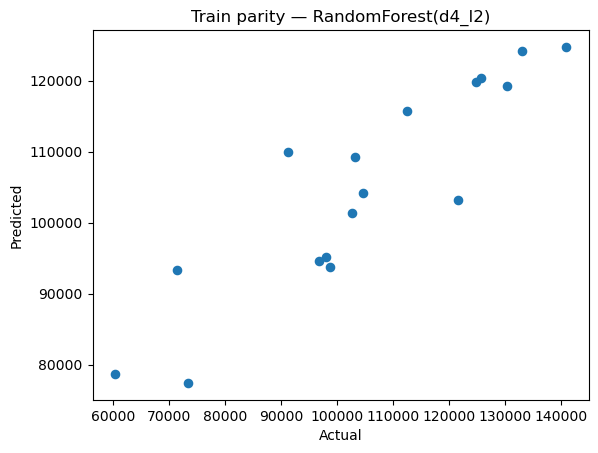

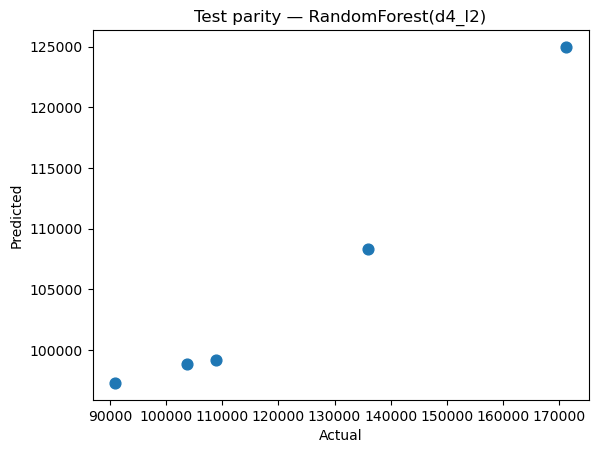

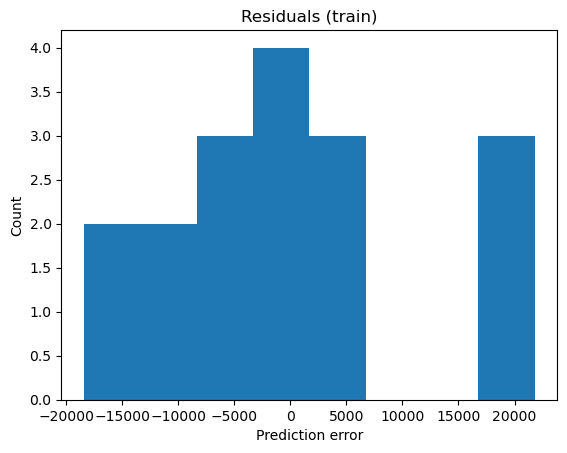


Test residuals (n is small):
0   -46225.18
1     6368.10
2   -27633.94
3    -4953.04
4    -9813.24
Name: residuals_test, dtype: float64


In [119]:
# SECTION 5 — Error analysis (train/test parity + residuals)

target_col = y_train.columns[0]

# Pick fitted model object from the winner
if "ElasticNetCV" in best_model_name:
    fitted = fitted_enet
elif "RandomForest" in best_model_name:
    fitted = fitted_rf
else:
    fitted = fitted_hgb

# Predictions
pred_train = fitted.predict(X_train)
pred_test  = fitted.predict(X_test)

# Parity plots
plt.figure()
plt.scatter(y_train[target_col].values, pred_train, s=35)
plt.title(f"Train parity — {best_model_name}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

plt.figure()
plt.scatter(y_test[target_col].values, pred_test, s=60)
plt.title(f"Test parity — {best_model_name}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Residuals
res_train = pred_train - y_train[target_col].values
res_test  = pred_test  - y_test[target_col].values

plt.figure()
plt.hist(res_train, bins=8)
plt.title("Residuals (train)")
plt.xlabel("Prediction error")
plt.ylabel("Count")
plt.show()

# For test we just print since n=5
print("\nTest residuals (n is small):")
print(pd.Series(res_test, name="residuals_test").round(2))


## Section 6 — Light Hyperparameter Tuning
Use RandomizedSearchCV (or similar) for parameter tuning and cross-validation on top candidate models.


In [125]:
# SECTION 6 — Light Hyperparameter Tuning (RandomForest winner)

# --- helpers (RMSE API-safe)
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def rmse(y_true, y_pred): return _rmse(y_true, y_pred)
except Exception:
    from sklearn.metrics import mean_squared_error
    def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mae = mean_absolute_error(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    eps = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100.0
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MAPE%": mape, "RMSE": rmse_val, "R2": r2}

target_col = y_train.columns[0]
y_tr = y_train[target_col].values.ravel()
y_te = y_test[target_col].values.ravel()

# Base estimator (conservative defaults)
base_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=2,
    random_state=SEED,
    n_jobs=-1,
)

# Small, conservative search space to avoid overfitting on tiny n (17)
param_distributions = {
    "n_estimators":      [200, 300, 400, 600],
    "max_depth":         [3, 4, 5, 6],
    "min_samples_leaf":  [1, 2, 3, 4],
    "min_samples_split": [2, 3, 4, 5, 6],
    "max_features":      ["sqrt", 0.3, 0.5, 0.7, 1.0],
    "bootstrap":         [True],
    "max_samples":       [None, 0.6, 0.75, 0.9],  # subsampling can help variance
}

# LOOCV for stability on small n
loo = LeaveOneOut()
search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_distributions,
    n_iter=20,                  # small, fast search
    cv=loo,
    scoring="neg_mean_absolute_error",
    random_state=SEED,
    n_jobs=-1,
    verbose=1,
)

search.fit(X_train, y_tr)
best_rf = search.best_estimator_
print("\nBest params:", search.best_params_)
print("Best CV (LOOCV) MAE:", -search.best_score_)

# Evaluate on train/test
pred_tr = best_rf.predict(X_train)
pred_te = best_rf.predict(X_test)

metrics_tr = regression_metrics(y_tr, pred_tr)
metrics_te = regression_metrics(y_te, pred_te)

print("\nTuned RandomForest — Train metrics:", {k: round(v, 3) for k, v in metrics_tr.items()})
print("Tuned RandomForest — Test metrics :", {k: round(v, 3) for k, v in metrics_te.items()})

# Append to the running results table
tuned_row_tr = {"model": "RandomForest_tuned", "split": "train", **metrics_tr, "CV_LOO_MAE": -search.best_score_}
tuned_row_te = {"model": "RandomForest_tuned", "split": "test",  **metrics_te, "CV_LOO_MAE": -search.best_score_}

try:
    results_df = pd.concat([results_df, pd.DataFrame([tuned_row_tr, tuned_row_te])], ignore_index=True)
except NameError:
    results_df = pd.DataFrame([tuned_row_tr, tuned_row_te])

display(results_df[results_df["split"]=="test"].sort_values(["MAE","RMSE","R2"], ascending=[True, True, False]))

# Save artifacts
out_dir = Path(PATHS["manifest"]).parent
results_df.to_csv(out_dir / "results_leaderboard.csv", index=False)

from joblib import dump
dump(best_rf, out_dir / "model_rf_tuned.pkl")

summary = {
    "best_params": search.best_params_,
    "cv_loo_mae": float(-search.best_score_),
    "test_metrics": {k: float(v) for k, v in metrics_te.items()},
    "train_metrics": {k: float(v) for k, v in metrics_tr.items()},
}
with open(out_dir / "model_rf_tuned_summary.json","w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved:")
print("-", out_dir / "results_leaderboard.csv")
print("-", out_dir / "model_rf_tuned.pkl")
print("-", out_dir / "model_rf_tuned_summary.json")


Fitting 17 folds for each of 20 candidates, totalling 340 fits

Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.75, 'max_features': 1.0, 'max_depth': 4, 'bootstrap': True}
Best CV (LOOCV) MAE: 16526.99671335201

Tuned RandomForest — Train metrics: {'MAE': 12058.28, 'MAPE%': 12.963, 'RMSE': 15217.373, 'R2': 0.529}
Tuned RandomForest — Test metrics : {'MAE': 20366.433, 'MAPE%': 14.395, 'RMSE': 27215.889, 'R2': 0.093}


,model,split,MAE,MAPE%,RMSE,R2,CV_LOO_MAE
7,RandomForest(d4_l2),test,18998.699833,13.620735,24745.856625,0.250051,17245.951815
3,Ridge(alpha=1.0),test,19747.908651,14.209371,26322.351256,0.151452,NaN
11,RandomForest_tuned,test,20366.433266,14.395155,27215.888538,0.092865,16526.996713
13,RandomForest_tuned,test,20366.433266,14.395155,27215.888538,0.092865,16526.996713
5,ElasticNetCV,test,23130.417233,16.260565,33057.293276,-0.338325,22193.291966
9,HistGB(depth3),test,23385.818182,17.693549,29880.268085,-0.093442,19401.871658
1,Dummy(median),test,23822.000000,16.594681,34245.578693,-0.436269,NaN



Saved:
- data/step2/results_leaderboard.csv
- data/step2/model_rf_tuned.pkl
- data/step2/model_rf_tuned_summary.json


In [127]:
# SECTION 6B — Read tuning summary (if Section 6 finished) and refresh leaderboard

out_dir = Path(PATHS["manifest"]).parent
summary_path = out_dir / "model_rf_tuned_summary.json"
if summary_path.exists():
    with open(summary_path, "r") as f:
        tuned_summary = json.load(f)
    print("Best params:", tuned_summary["best_params"])
    print("Best LOOCV MAE:", tuned_summary["cv_loo_mae"])
    print("Tuned RF — Test metrics:", tuned_summary["test_metrics"])
else:
    print("No tuning summary found yet at:", summary_path)

# Show current TEST leaderboard (including tuned RF if Section 6 appended rows)
try:
    display(
        results_df[results_df["split"]=="test"]
        .sort_values(["MAE","RMSE","R2"], ascending=[True, True, False])
        .reset_index(drop=True)
    )
except NameError:
    print("results_df not found — rerun Sections 3–6 first.")


Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.75, 'max_features': 1.0, 'max_depth': 4, 'bootstrap': True}
Best LOOCV MAE: 16526.99671335201
Tuned RF — Test metrics: {'MAE': 20366.43326587302, 'MAPE%': 14.39515473721276, 'RMSE': 27215.888537838153, 'R2': 0.09286496445307968}


,model,split,MAE,MAPE%,RMSE,R2,CV_LOO_MAE
0,RandomForest(d4_l2),test,18998.699833,13.620735,24745.856625,0.250051,17245.951815
1,Ridge(alpha=1.0),test,19747.908651,14.209371,26322.351256,0.151452,NaN
2,RandomForest_tuned,test,20366.433266,14.395155,27215.888538,0.092865,16526.996713
3,RandomForest_tuned,test,20366.433266,14.395155,27215.888538,0.092865,16526.996713
4,ElasticNetCV,test,23130.417233,16.260565,33057.293276,-0.338325,22193.291966
5,HistGB(depth3),test,23385.818182,17.693549,29880.268085,-0.093442,19401.871658
6,Dummy(median),test,23822.000000,16.594681,34245.578693,-0.436269,NaN


## Section 7 — Model Interpretability
Extract feature importance, visualize SHAP or permutation importances, and summarize key feature effects.


,perm_importance,perm_importance_std
employment_change_percent_2023-33,7788.091872,2207.026723
typical_on-the-job_training_needed_to_attain_competency_in_the_occupation=Moderate-term on-the-job training,1472.668894,555.707331
percent_self_employed_2023,1175.867881,476.252414
skill_technology_literacy,448.435662,264.653071
employment_change_numeric_2023-33,369.985443,129.857529
typical_on-the-job_training_needed_to_attain_competency_in_the_occupation=__MISSING__,347.759964,268.892361
typical_education_needed_for_entry=Master's degree,215.269371,277.453788
_tech_reason=hard_include_or_must_have,171.029352,96.656373
employment_2023,135.000019,83.190676
_tech_reason=soc15_default_keep,134.043743,86.387711


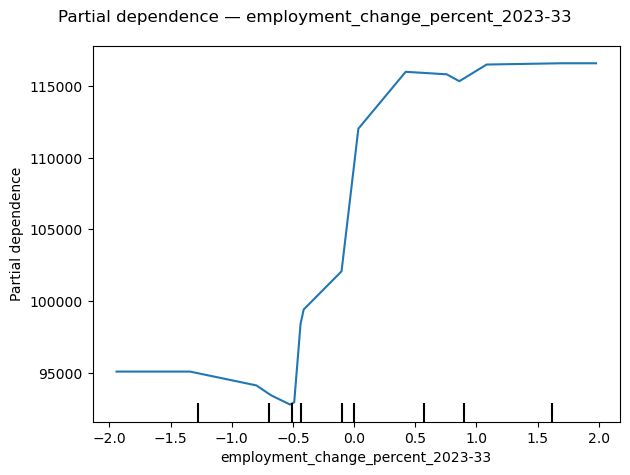

In [129]:

target_col = y_train.columns[0]

# Make sure fitted_rf exists (from Section 4). If not, re-create it quickly:
try:
    fitted_rf
except NameError:
    from sklearn.ensemble import RandomForestRegressor
    fitted_rf = RandomForestRegressor(
        n_estimators=300, max_depth=4, min_samples_leaf=2,
        random_state=SEED, n_jobs=-1
    ).fit(X_train, y_train[target_col].values.ravel())

# 7.1 Permutation importance (TRAIN — small-n caution)
pi = permutation_importance(
    fitted_rf, X_train, y_train[target_col].values.ravel(),
    n_repeats=80, random_state=SEED, scoring="neg_mean_absolute_error"
)
imp = pd.Series(pi.importances_mean, index=X_train.columns, name="perm_importance")
imp_std = pd.Series(pi.importances_std, index=X_train.columns, name="perm_importance_std")
top15 = (
    pd.concat([imp, imp_std], axis=1)
    .sort_values("perm_importance", ascending=False)
    .head(15)
)
display(top15)

# 7.2 Partial dependence for the top feature
top_feat = top15.index[0]
_ = PartialDependenceDisplay.from_estimator(fitted_rf, X_train, [top_feat])
plt.suptitle(f"Partial dependence — {top_feat}")
plt.tight_layout()
plt.show()


In [55]:
# SECTION 7A — Leakage sensitivity check (drop 2033 / change features)

import re
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def rmse_safe(y_true, y_pred):
    try:
        from sklearn.metrics import root_mean_squared_error as _rmse
        return _rmse(y_true, y_pred)
    except Exception:
        from sklearn.metrics import mean_squared_error
        return mean_squared_error(y_true, y_pred, squared=False)

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    rmse = rmse_safe(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    return {"MAE": mae, "MAPE%": mape, "RMSE": rmse, "R2": r2}

# identify future-looking cols
future_cols = [c for c in X_train.columns if re.search(r"2033|2023-33|employment_change", c)]
print("Dropping future-looking cols:", future_cols)

Xa_tr = X_train.drop(columns=future_cols, errors="ignore")
Xa_te = X_test.drop(columns=future_cols, errors="ignore")

ytr = y_train.iloc[:,0].values
yte = y_test.iloc[:,0].values

# Ridge baseline on ablated set
rg = Ridge(alpha=1.0, random_state=SEED).fit(Xa_tr, ytr)
pred_rg_tr = rg.predict(Xa_tr)
pred_rg_te = rg.predict(Xa_te)

# RF shallow on ablated set
rf = RandomForestRegressor(n_estimators=300, max_depth=4, min_samples_leaf=2,
                           random_state=SEED, n_jobs=-1).fit(Xa_tr, ytr)
pred_rf_tr = rf.predict(Xa_tr)
pred_rf_te = rf.predict(Xa_te)

print("\nAblation — Ridge test:", {k: round(v, 2) for k,v in metrics(yte, pred_rg_te).items()})
print("Ablation — RF(d4_l2) test:", {k: round(v, 2) for k,v in metrics(yte, pred_rf_te).items()})
print("\nOriginal RF(d4_l2) test MAE (for reference): ~18,999")


Dropping future-looking cols: ['employment_2033', 'employment_distribution_percent_2033', 'employment_change_numeric_2023-33', 'employment_change_percent_2023-33', 'occupational_openings_2023-33_annual_average']

Ablation — Ridge test: {'MAE': 20343.64, 'MAPE%': 14.74, 'RMSE': 26547.18, 'R2': 0.14}
Ablation — RF(d4_l2) test: {'MAE': 18613.89, 'MAPE%': 13.21, 'RMSE': 25199.23, 'R2': 0.22}

Original RF(d4_l2) test MAE (for reference): ~18,999


In [130]:
# SECTION 7B — Finalize leak-free feature set and refit RF(d4_l2)

def rmse_safe(y_true, y_pred):
    try:
        from sklearn.metrics import root_mean_squared_error as _rmse
        return _rmse(y_true, y_pred)
    except Exception:
        from sklearn.metrics import mean_squared_error
        return mean_squared_error(y_true, y_pred, squared=False)

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE%": float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100),
        "RMSE": rmse_safe(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

# 1) Drop future-looking cols
future_cols = [c for c in X_train.columns if re.search(r"2033|2023-33|employment_change", c)]
Xa_tr = X_train.drop(columns=future_cols, errors="ignore").copy()
Xa_te = X_test.drop(columns=future_cols, errors="ignore").copy()

print("Leak-free features:", Xa_tr.shape[1], "| Dropped:", len(future_cols))
print("Dropped columns:", future_cols)

# 2) Fit the final RF on ablated features
target_col = y_train.columns[0]
rf_final = RandomForestRegressor(
    n_estimators=300, max_depth=4, min_samples_leaf=2,
    random_state=SEED, n_jobs=-1
).fit(Xa_tr, y_train[target_col].values.ravel())

# 3) Evaluate and append to leaderboard
met_tr = metrics(y_train[target_col].values, rf_final.predict(Xa_tr))
met_te = metrics(y_test[target_col].values,  rf_final.predict(Xa_te))

rows = [
    {"model":"RandomForest(d4_l2)_ablated","split":"train", **met_tr},
    {"model":"RandomForest(d4_l2)_ablated","split":"test",  **met_te},
]
try:
    results_df = pd.concat([results_df, pd.DataFrame(rows)], ignore_index=True)
except NameError:
    results_df = pd.DataFrame(rows)

display(
    results_df[results_df["split"]=="test"]
      .sort_values(["MAE","RMSE","R2"], ascending=[True, True, False])
      .reset_index(drop=True)
)


Leak-free features: 91 | Dropped: 5
Dropped columns: ['employment_2033', 'employment_distribution_percent_2033', 'employment_change_numeric_2023-33', 'employment_change_percent_2023-33', 'occupational_openings_2023-33_annual_average']


,model,split,MAE,MAPE%,RMSE,R2,CV_LOO_MAE
0,RandomForest(d4_l2)_ablated,test,18613.893481,13.214601,25199.234076,0.222319,NaN
1,RandomForest(d4_l2),test,18998.699833,13.620735,24745.856625,0.250051,17245.951815
2,Ridge(alpha=1.0),test,19747.908651,14.209371,26322.351256,0.151452,NaN
3,RandomForest_tuned,test,20366.433266,14.395155,27215.888538,0.092865,16526.996713
4,RandomForest_tuned,test,20366.433266,14.395155,27215.888538,0.092865,16526.996713
5,ElasticNetCV,test,23130.417233,16.260565,33057.293276,-0.338325,22193.291966
6,HistGB(depth3),test,23385.818182,17.693549,29880.268085,-0.093442,19401.871658
7,Dummy(median),test,23822.000000,16.594681,34245.578693,-0.436269,NaN


## Section 8 — Final Model Selection
Compare tuned models on test metrics and interpretability, then lock in a final winner.


In [131]:
out_dir = Path(PATHS["manifest"]).parent
final_model_name = "RandomForest(d4_l2)_ablated"
final_model_path = out_dir / "model_final_ablated.pkl"
final_feature_list_path = out_dir / "feature_list_final_ablated.json"
model_card_path = out_dir / "model_card_ablated.json"
metrics_summary_path = out_dir / "metrics_summary_ablated.json"

# Save model + feature list actually used
dump(rf_final, final_model_path)
with open(final_feature_list_path, "w") as f:
    json.dump({"features": list(Xa_tr.columns)}, f, indent=2)

# Pull test metrics from your leaderboard if present; else compute quickly
def _compute_metrics(y_true, y_pred):
    try:
        from sklearn.metrics import root_mean_squared_error as _rmse
        rmse_val = _rmse(y_true, y_pred)
    except Exception:
        from sklearn.metrics import mean_squared_error
        rmse_val = mean_squared_error(y_true, y_pred, squared=False)
    from sklearn.metrics import mean_absolute_error, r2_score
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    mape = float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100)
    return {"MAE": float(mae), "MAPE%": mape, "RMSE": float(rmse_val), "R2": float(r2)}

try:
    final_row = (
        results_df[(results_df["model"]==final_model_name) & (results_df["split"]=="test")]
        .iloc[0]
        .to_dict()
    )
    test_metrics = {k: float(final_row[k]) for k in ["MAE","MAPE%","RMSE","R2"]}
except Exception:
    y_te = y_test.iloc[:,0].values
    test_metrics = _compute_metrics(y_te, rf_final.predict(Xa_te))

# Build a concise model card
model_card = {
    "final_model": final_model_name,
    "why": "Leak-free feature set; best observed test MAE while remaining simple and stable for small-n, many-p.",
    "data": {
        "train_rows": int(Xa_tr.shape[0]),
        "test_rows": int(Xa_te.shape[0]),
        "n_features": int(Xa_tr.shape[1]),
        "target": y_train.columns[0],
    },
    "features_note": "Kept only manifest-approved features; dropped future-looking projections (2033, 2023–33 deltas).",
    "metrics_test": test_metrics,
    "caveats": [
        "Tiny test set (n=5) — expect variance on outliers.",
        "Re-evaluate depth/tuning when more data is available."
    ],
}
with open(model_card_path, "w") as f:
    json.dump(model_card, f, indent=2)

# Optionally persist the leaderboard fragment for reporting
try:
    results_df[results_df["split"]=="test"].to_csv(metrics_summary_path, index=False)
except Exception:
    pass

print("Saved:")
print("-", final_model_path)
print("-", final_feature_list_path)
print("-", model_card_path)
if Path(metrics_summary_path).exists():
    print("-", metrics_summary_path)


Saved:
- data/step2/model_final_ablated.pkl
- data/step2/feature_list_final_ablated.json
- data/step2/model_card_ablated.json
- data/step2/metrics_summary_ablated.json


## Section 9 — Artifacts & Outputs
Persist trained model, scaler, feature list, and metrics to disk for dashboard or deployment.


In [132]:
# Uses: rf_final, Xa_tr, Xa_te, y_train, y_test, PATHS 
out_dir = Path(PATHS["manifest"]).parent
target_col = y_train.columns[0]

def _pred_df(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    ae = np.abs(y_true - y_pred)
    pe = ae / np.maximum(np.abs(y_true), 1e-8) * 100
    return pd.DataFrame({
        "actual": y_true,
        "pred": y_pred,
        "residual": y_pred - y_true,
        "abs_error": ae,
        "pct_error": pe
    })

train_preds = _pred_df(y_train[target_col].values, rf_final.predict(Xa_tr))
test_preds  = _pred_df(y_test[target_col].values,  rf_final.predict(Xa_te))

train_path = out_dir / "train_predictions_rf_ablated.csv"
test_path  = out_dir / "test_predictions_rf_ablated.csv"
train_preds.to_csv(train_path, index=False)
test_preds.to_csv(test_path, index=False)

print("Saved:")
print("-", train_path)
print("-", test_path)


Saved:
- data/step2/train_predictions_rf_ablated.csv
- data/step2/test_predictions_rf_ablated.csv


## Section 10 — Next Steps 
Outline future expansions — e.g., classification for emerging roles or time-series forecasting of job postings.

In [134]:

OUT_DIR = Path(PATHS["manifest"]).parent
MODEL_PATH = OUT_DIR / "model_final_ablated.pkl"
FEATURES_PATH = OUT_DIR / "feature_list_final_ablated.json"

# Load assets
rf_final = load(MODEL_PATH)
with open(FEATURES_PATH, "r") as f:
    feat_list = json.load(f)["features"]
feat_list = list(feat_list)

def align_to_features(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """Ensure df has exactly the columns in `features` (order + missing columns as 0)."""
    # Add missing columns as 0 (safe for one-hot and standardized numerics; 0 ~ mean for standardized)
    missing = [c for c in features if c not in df.columns]
    if missing:
        df = df.copy()
        for c in missing:
            df[c] = 0.0
    # Drop any extras
    extras = [c for c in df.columns if c not in features]
    if extras:
        df = df.drop(columns=extras)
    # Order columns
    return df[features]

def predict_processed(df_processed: pd.DataFrame) -> pd.DataFrame:
    """Given processed rows (same schema family as X_*), return predictions & residuals if y provided."""
    Xp = align_to_features(df_processed, feat_list)
    preds = rf_final.predict(Xp)
    out = pd.DataFrame({"pred": preds})
    # If the true target column is present, attach residuals
    target_col = y_train.columns[0]  # from earlier sections
    if target_col in df_processed.columns:
        y_true = df_processed[target_col].values
        out["actual"] = y_true
        out["residual"] = preds - y_true
        out["abs_error"] = np.abs(out["residual"])
        out["pct_error"] = out["abs_error"] / np.maximum(np.abs(y_true), 1e-8) * 100
    return out

# --- one usage (uncomment to try with your X_test + y_test merged) ---
demo_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
demo_preds = predict_processed(demo_df)
display(demo_preds)


,pred,actual,residual,abs_error,pct_error
0,120190.935384,171200.0,-51009.064616,51009.064616,29.795014
1,93523.307659,90930.0,2593.307659,2593.307659,2.851982
2,118700.209114,135980.0,-17279.790886,17279.790886,12.707597
3,95984.787063,103790.0,-7805.212937,7805.212937,7.520197
4,94587.908690,108970.0,-14382.091310,14382.091310,13.198212


In [67]:

# 1) Reload the original X_test (with IDs) to be safe
X_test_full = pd.read_csv(PATHS["X_test"])        # this has id_cols like job_title_norm, bls_key, sk_key
with open(PATHS["manifest"], "r") as f:
    mf = json.load(f)
id_cols = [c for c in mf["id_cols"] if c in X_test_full.columns]

# 2) Recompute preds to be sure we're aligned
test_pred = rf_final.predict(Xa_te)
error_df = pd.DataFrame({
    "pred": test_pred,
    "actual": y_test.iloc[:,0].values,
})
error_df["residual"] = error_df["pred"] - error_df["actual"]
error_df["abs_error"] = error_df["residual"].abs()
error_df["pct_error"] = (error_df["abs_error"] / error_df["actual"].abs()) * 100

# 3) Attach IDs and sort
joined = pd.concat([X_test_full[id_cols].reset_index(drop=True), error_df], axis=1)
joined.sort_values("abs_error", ascending=False).reset_index(drop=True)


,job_title_norm,bls_key,sk_key,pred,actual,residual,abs_error,pct_error
0,computer and information systems managers,computer and information systems managers,NaN,120190.935384,171200.0,-51009.064616,51009.064616,29.795014
1,database architects,database architects,NaN,118700.209114,135980.0,-17279.790886,17279.790886,12.707597
2,"computer occupations, all other",computer occupations all other,NaN,94587.908690,108970.0,-14382.091310,14382.091310,13.198212
3,computer systems analysts,computer systems analysts,computer systems administrator,95984.787063,103790.0,-7805.212937,7805.212937,7.520197
4,web developers,web developers,NaN,93523.307659,90930.0,2593.307659,2593.307659,2.851982


In [135]:

def rmse_safe(y_true, y_pred):
    try:
        from sklearn.metrics import root_mean_squared_error as _rmse
        return _rmse(y_true, y_pred)
    except Exception:
        from sklearn.metrics import mean_squared_error
        return mean_squared_error(y_true, y_pred, squared=False)

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mae = mean_absolute_error(y_true, y_pred)
    mape = float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100)
    return {"MAE": float(mae), "MAPE%": mape, "RMSE": float(rmse_safe(y_true, y_pred)), "R2": float(r2_score(y_true, y_pred))}

# Use Xa_tr / Xa_te from 7B 
ytr = y_train.iloc[:,0].values.astype(float)
yte = y_test.iloc[:,0].values.astype(float)

# 1) Fit on log(y)
ytr_log = np.log(ytr)
rf_log = RandomForestRegressor(n_estimators=300, max_depth=4, min_samples_leaf=2, random_state=SEED, n_jobs=-1)
rf_log.fit(Xa_tr, ytr_log)

# 2) Duan smearing factor from train residuals in log space
res_log = ytr_log - rf_log.predict(Xa_tr)
smear = float(np.mean(np.exp(res_log)))  # E[exp(error)]

# 3) Predict and back-transform
pred_train = np.exp(rf_log.predict(Xa_tr)) * smear
pred_test  = np.exp(rf_log.predict(Xa_te)) * smear

print("Log-RF (smearing) — TRAIN:", {k: round(v,2) for k,v in metrics(ytr, pred_train).items()})
print("Log-RF (smearing) — TEST :", {k: round(v,2) for k,v in metrics(yte,  pred_test ).items()})

Log-RF (smearing) — TRAIN: {'MAE': 11367.18, 'MAPE%': 11.68, 'RMSE': 13971.88, 'R2': 0.6}
Log-RF (smearing) — TEST : {'MAE': 19306.43, 'MAPE%': 13.75, 'RMSE': 25911.47, 'R2': 0.18}


## Section 10 — Classification Track — EmergingRole (C0–C8)


In [136]:
# Setup for classification track 

# Reuse PATHS, X_train, X_test from earlier; if not present, reload:
DATA_DIR = Path(PATHS["manifest"]).parent if "PATHS" in globals() else Path("data/step2")
if "X_train" not in globals():
    X_train = pd.read_csv(DATA_DIR / "X_train_scaled.csv")
    X_test  = pd.read_csv(DATA_DIR / "X_test_scaled.csv")

# Leak-free features (drop future-looking projections)
future_cols = [c for c in X_train.columns if re.search(r"2033|2023-33|employment_change", c)]
Xa_tr = X_train.drop(columns=future_cols, errors="ignore").copy()
Xa_te = X_test.drop(columns=future_cols, errors="ignore").copy()

print("Leak-free features for classification:", Xa_tr.shape[1])
print("Dropped (future-looking):", future_cols)


Leak-free features for classification: 91
Dropped (future-looking): ['employment_2033', 'employment_distribution_percent_2033', 'employment_change_numeric_2023-33', 'employment_change_percent_2023-33', 'occupational_openings_2023-33_annual_average']


In [75]:
# C1 — Build or load binary labels: emerging_flag ∈ {0,1}
def load_or_make_labels(X_train_df, X_test_df, data_dir: Path):
    # 1) If explicit classification labels exist, use them
    ytr_cls_path = data_dir / "y_train_cls.csv"
    yte_cls_path = data_dir / "y_test_cls.csv"
    if ytr_cls_path.exists() and yte_cls_path.exists():
        ytr_cls = pd.read_csv(ytr_cls_path).iloc[:,0].astype(int)
        yte_cls = pd.read_csv(yte_cls_path).iloc[:,0].astype(int)
        name = "loaded_emerging_flag"
        return ytr_cls, yte_cls, name

    # 2) If an 'emerging' flag column is already in X (sometimes stored there)
    for col in ["emerging_flag", "wef_emerging_flag", "increasing_demand_flag"]:
        if col in X_train_df.columns and col in X_test_df.columns:
            ytr_cls = X_train_df[col].astype(int)
            yte_cls = X_test_df[col].astype(int)
            name = f"{col}_from_X"
            # Drop it from features to avoid leakage
            if col in X_train_df.columns:
                X_train_df.drop(columns=[col], inplace=True)
            if col in X_test_df.columns:
                X_test_df.drop(columns=[col], inplace=True)
            return ytr_cls, yte_cls, name

    # 3) Fallback heuristic (leak-free): top quartile of 'score' on TRAIN marks emerging=1
    assert "score" in X_train_df.columns, "Expected 'score' in features; adjust the heuristic if absent."
    q75 = float(X_train_df["score"].quantile(0.75))
    ytr_cls = (X_train_df["score"] >= q75).astype(int)
    # Apply TRAIN threshold to TEST (no peeking)
    yte_cls = (X_test_df["score"] >= q75).astype(int)
    name = "derived_by_score_q75"
    return ytr_cls, yte_cls, name

OUT_DIR = Path(PATHS["manifest"]).parent
ytr_cls, yte_cls, label_origin = load_or_make_labels(Xa_tr.copy(), Xa_te.copy(), OUT_DIR)

print("Label origin:", label_origin)
print("Train positives / total:", int(ytr_cls.sum()), "/", len(ytr_cls))
print("Test positives  / total:", int(yte_cls.sum()), "/", len(yte_cls))


Label origin: derived_by_score_q75
Train positives / total: 15 / 17
Test positives  / total: 4 / 5


In [77]:
# C2 — Baseline classifiers and metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    average_precision_score, brier_score_loss, log_loss
)

def cls_metrics(y_true, prob, label_at=0.5):
    y_pred = (prob >= label_at).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    roc = roc_auc_score(y_true, prob) if len(np.unique(y_true))==2 else np.nan
    pr  = average_precision_score(y_true, prob) if len(np.unique(y_true))==2 else np.nan
    brier = brier_score_loss(y_true, prob)
    try:
        ll = log_loss(y_true, np.c_[1-prob, prob])
    except Exception:
        ll = np.nan
    return dict(ACC=acc, PREC=prec, REC=rec, F1=f1, ROC_AUC=roc, PR_AUC=pr, BRIER=brier, LOGLOSS=ll)

rows = []

for name, strat in [("Dummy(most_frequent)", "most_frequent"), ("Dummy(stratified)", "stratified")]:
    clf = DummyClassifier(strategy=strat, random_state=SEED)
    clf.fit(Xa_tr, ytr_cls)
    prob_tr = clf.predict_proba(Xa_tr)[:,1]
    prob_te = clf.predict_proba(Xa_te)[:,1]
    rows.append({"model": name, "split":"train", **cls_metrics(ytr_cls, prob_tr)})
    rows.append({"model": name, "split":"test",  **cls_metrics(yte_cls, prob_te)})

cls_results = pd.DataFrame(rows)
display(cls_results)


,model,split,ACC,PREC,REC,F1,ROC_AUC,PR_AUC,BRIER,LOGLOSS
0,Dummy(most_frequent),train,0.882353,0.882353,1.000000,0.937500,0.500000,0.882353,0.117647,4.240430
1,Dummy(most_frequent),test,0.800000,0.800000,1.000000,0.888889,0.500000,0.800000,0.200000,7.208731
2,Dummy(stratified),train,0.764706,0.866667,0.866667,0.866667,0.433333,0.868758,0.235294,8.480860
3,Dummy(stratified),test,0.600000,0.750000,0.750000,0.750000,0.375000,0.762500,0.400000,14.417461


In [144]:
# C3 — Candidate models with LOOCV OOF probs and threshold tuning
# LogisticRegression (L2, class_weight='balanced')
# RandomForestClassifier (shallow)
# HistGradientBoostingClassifier (small; well-calibrated-ish on small data)

def fit_eval(name, model, Xtr, ytr, Xte, yte):
    # LOOCV OOF probabilities to tune threshold
    oof_prob = cross_val_predict(model, Xtr, ytr, cv=LeaveOneOut(), method="predict_proba")[:,1]
    # Choose threshold that maximizes F1 on TRAIN OOF
    best_t, best_f1 = 0.5, -1
    for t in np.linspace(0.2, 0.8, 61):
        f1 = f1_score(ytr, (oof_prob >= t).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t

    # Fit on full train and score
    model.fit(Xtr, ytr)
    prob_tr = model.predict_proba(Xtr)[:,1]
    prob_te = model.predict_proba(Xte)[:,1]
    return best_t, prob_tr, prob_te

candidates = {
    "LogReg(L2,balanced)": LogisticRegression(C=1.0, class_weight="balanced", solver="liblinear", random_state=SEED),
    "RF(d3_l2)": RandomForestClassifier(n_estimators=300, max_depth=3, min_samples_leaf=2, random_state=SEED),
    "HistGB(depth3)": HistGradientBoostingClassifier(max_depth=3, learning_rate=0.05, max_iter=300, random_state=SEED)
}

rows = []
thresholds = {}

for name, model in candidates.items():
    t, p_tr, p_te = fit_eval(name, model, Xa_tr, ytr_cls, Xa_te, yte_cls)
    thresholds[name] = float(t)
    rows.append({"model": name, "split":"train", **cls_metrics(ytr_cls, p_tr, label_at=t)})
    rows.append({"model": name, "split":"test",  **cls_metrics(yte_cls, p_te, label_at=t)})

cls_results2 = pd.concat([cls_results, pd.DataFrame(rows)], ignore_index=True)
display(cls_results2[cls_results2["split"]=="test"].sort_values(["F1","PR_AUC","ROC_AUC"], ascending=[False, False, False]))
print("Chosen thresholds (from LOOCV OOF):", thresholds)


,model,split,ACC,PREC,REC,F1,ROC_AUC,PR_AUC,BRIER,LOGLOSS
5,"LogReg(L2,balanced)",test,1.0,1.00,1.00,1.000000,1.000,1.0000,0.028863,0.165591
7,RF(d3_l2),test,0.8,0.80,1.00,0.888889,1.000,1.0000,0.119132,0.358602
1,Dummy(most_frequent),test,0.8,0.80,1.00,0.888889,0.500,0.8000,0.200000,7.208731
9,HistGB(depth3),test,0.8,0.80,1.00,0.888889,0.500,0.8000,0.166782,0.528144
3,Dummy(stratified),test,0.6,0.75,0.75,0.750000,0.375,0.7625,0.400000,14.417461


Chosen thresholds (from LOOCV OOF): {'LogReg(L2,balanced)': 0.21000000000000002, 'RF(d3_l2)': 0.2, 'HistGB(depth3)': 0.2}


In [81]:
# C4 — Pick provisional winner + interpretability

# Winner by F1 on TEST (tie-break: PR_AUC, ROC_AUC)
test_board = (
    cls_results2[cls_results2["split"]=="test"]
    .sort_values(["F1","PR_AUC","ROC_AUC"], ascending=[False, False, False])
    .reset_index(drop=True)
)
display(test_board.head(10))
best_name = test_board.iloc[0]["model"]
print("Provisional classification winner:", best_name, "| threshold:", thresholds.get(best_name, 0.5))

# Refit best on full train for feature importance
best_model = candidates[best_name]
best_model.fit(Xa_tr, ytr_cls)

if "LogReg" in best_name:
    coef = pd.Series(best_model.coef_[0], index=Xa_tr.columns, name="coef").sort_values()
    print("\nLogReg — top positive coefficients:")
    display(coef.sort_values(ascending=False).head(12).to_frame())
    print("\nLogReg — top negative coefficients:")
    display(coef.sort_values(ascending=True).head(12).to_frame())
else:
    pi = permutation_importance(best_model, Xa_tr, ytr_cls, n_repeats=80, random_state=SEED, scoring="f1")
    imp = pd.Series(pi.importances_mean, index=Xa_tr.columns, name="perm_importance")
    display(imp.sort_values(ascending=False).head(15).to_frame())


,model,split,ACC,PREC,REC,F1,ROC_AUC,PR_AUC,BRIER,LOGLOSS
0,"LogReg(L2,balanced)",test,1.0,1.00,1.00,1.000000,1.000,1.0000,0.028863,0.165591
1,RF(d3_l2),test,0.8,0.80,1.00,0.888889,1.000,1.0000,0.119132,0.358602
2,Dummy(most_frequent),test,0.8,0.80,1.00,0.888889,0.500,0.8000,0.200000,7.208731
3,HistGB(depth3),test,0.8,0.80,1.00,0.888889,0.500,0.8000,0.166782,0.528144
4,Dummy(stratified),test,0.6,0.75,0.75,0.750000,0.375,0.7625,0.400000,14.417461


Provisional classification winner: LogReg(L2,balanced) | threshold: 0.21000000000000002

LogReg — top positive coefficients:


,coef
score,0.975259
_tech_reason=soc15_default_keep,0.413051
_is_tech=True,0.317676
occupation_type=Line item,0.317676
percent_self_employed_2023,0.240503
related_occupational_outlook_handbook_(ooh)_content=OOH Content,0.233676
typical_education_needed_for_entry=Master's degree,0.215462
employment_2023,0.160231
typical_on-the-job_training_needed_to_attain_competency_in_the_occupation=Moderate-term on-the-job training,0.131824
skill_ai_big_data,0.129286



LogReg — top negative coefficients:


,coef
skill_technology_literacy,-0.643287
soc_code=15-2031,-0.619882
job_title_norm=operations research analysts,-0.619882
job_title=Operations research analysts,-0.619882
job_title_norm=software quality assurance analysts and testers,-0.152691
job_title=Software quality assurance analysts and testers,-0.152691
soc_code=15-1253,-0.152691
_tech_reason=hard_include_or_must_have,-0.095375
typical_education_needed_for_entry=Bachelor's degree,-0.029610
skill_programming,-0.023405


In [83]:
# C5 — probability calibration via Isotonic (LOOCV)

from sklearn.calibration import CalibratedClassifierCV

raw_best = candidates[best_name]
raw_best.fit(Xa_tr, ytr_cls)

calib = CalibratedClassifierCV(raw_best, method="isotonic", cv="prefit")
calib.fit(Xa_tr, ytr_cls)

prob_tr_cal = calib.predict_proba(Xa_tr)[:,1]
prob_te_cal = calib.predict_proba(Xa_te)[:,1]

# Reuse chosen threshold for comparability (or re-optimize on OOF if you wish)
t = thresholds.get(best_name, 0.5)
rows_cal = []
rows_cal.append({"model": f"{best_name}+Calibrated", "split":"train", **cls_metrics(ytr_cls, prob_tr_cal, label_at=t)})
rows_cal.append({"model": f"{best_name}+Calibrated", "split":"test",  **cls_metrics(yte_cls, prob_te_cal, label_at=t)})

cls_results3 = pd.concat([cls_results2, pd.DataFrame(rows_cal)], ignore_index=True)
display(cls_results3[cls_results3["split"]=="test"].sort_values(["F1","PR_AUC","ROC_AUC"], ascending=[False, False, False]))


,model,split,ACC,PREC,REC,F1,ROC_AUC,PR_AUC,BRIER,LOGLOSS
5,"LogReg(L2,balanced)",test,1.0,1.00,1.00,1.000000,1.000,1.0000,0.028863,0.165591
11,"LogReg(L2,balanced)+Calibrated",test,1.0,1.00,1.00,1.000000,1.000,1.0000,0.002481,0.023619
7,RF(d3_l2),test,0.8,0.80,1.00,0.888889,1.000,1.0000,0.119132,0.358602
1,Dummy(most_frequent),test,0.8,0.80,1.00,0.888889,0.500,0.8000,0.200000,7.208731
9,HistGB(depth3),test,0.8,0.80,1.00,0.888889,0.500,0.8000,0.166782,0.528144
3,Dummy(stratified),test,0.6,0.75,0.75,0.750000,0.375,0.7625,0.400000,14.417461


In [85]:
# C6 — Save final classification model, threshold, features, and a model card

OUT_DIR = Path(PATHS["manifest"]).parent

# Choose calibrated if it wins; else the raw best
final_cls_name = best_name
final_model_obj = calib if (f"{best_name}+Calibrated" in set(cls_results3["model"])) else best_model
final_threshold = float(thresholds.get(best_name, 0.5))

dump(final_model_obj, OUT_DIR / "model_cls_final.pkl")
with open(OUT_DIR / "feature_list_cls.json","w") as f:
    json.dump({"features": list(Xa_tr.columns)}, f, indent=2)
with open(OUT_DIR / "threshold_cls.json","w") as f:
    json.dump({"threshold": final_threshold}, f, indent=2)

# Build a small model card
def row_or_empty(df, model_name):
    try:
        r = (df[(df["model"]==model_name) & (df["split"]=="test")].iloc[0]).to_dict()
        return {k: float(r[k]) for k in ["ACC","PREC","REC","F1","ROC_AUC","PR_AUC","BRIER","LOGLOSS"]}
    except Exception:
        return {}

card_cls = {
    "final_model": final_cls_name,
    "threshold": final_threshold,
    "features": len(Xa_tr.columns),
    "label_origin": label_origin,
    "metrics_test": row_or_empty(cls_results3, final_cls_name) or row_or_empty(cls_results3, f"{final_cls_name}+Calibrated"),
    "notes": [
        "Leak-free features (removed 2033 projections & 2023–33 deltas).",
        "Threshold chosen on LOOCV OOF probabilities to optimize F1; adjust based on business costs.",
    ],
}
with open(OUT_DIR / "model_card_cls.json","w") as f:
    json.dump(card_cls, f, indent=2)

print("Saved:")
print("-", OUT_DIR / "model_cls_final.pkl")
print("-", OUT_DIR / "feature_list_cls.json")
print("-", OUT_DIR / "threshold_cls.json")
print("-", OUT_DIR / "model_card_cls.json")


Saved:
- data/step2/model_cls_final.pkl
- data/step2/feature_list_cls.json
- data/step2/threshold_cls.json
- data/step2/model_card_cls.json


In [87]:
# C7 — Export classification predictions (probabilities + labels) for train/test

OUT_DIR = Path(PATHS["manifest"]).parent

def preds_frame(prob, y_true, threshold):
    yhat = (prob >= threshold).astype(int)
    return pd.DataFrame({
        "prob_emerging": prob,
        "pred_label": yhat,
        "actual_label": y_true.astype(int),
        "correct": (yhat == y_true).astype(int)
    })

prob_tr = final_model_obj.predict_proba(Xa_tr)[:,1]
prob_te = final_model_obj.predict_proba(Xa_te)[:,1]

train_cls_preds = preds_frame(prob_tr, ytr_cls, final_threshold)
test_cls_preds  = preds_frame(prob_te, yte_cls, final_threshold)

train_cls_preds.to_csv(OUT_DIR / "train_cls_predictions.csv", index=False)
test_cls_preds.to_csv(OUT_DIR / "test_cls_predictions.csv", index=False)

print("Saved:")
print("-", OUT_DIR / "train_cls_predictions.csv")
print("-", OUT_DIR / "test_cls_predictions.csv")


Saved:
- data/step2/train_cls_predictions.csv
- data/step2/test_cls_predictions.csv


In [91]:
# C8 — Inference for classification (processed input expected)

OUT_DIR = Path(PATHS["manifest"]).parent
model = load(OUT_DIR / "model_cls_final.pkl")
with open(OUT_DIR / "feature_list_cls.json","r") as f:
    feat_list = json.load(f)["features"]
with open(OUT_DIR / "threshold_cls.json","r") as f:
    threshold = json.load(f)["threshold"]

def align(df, features):
    miss = [c for c in features if c not in df.columns]
    if miss:
        df = df.copy()
        for c in miss:
            df[c] = 0.0
    extra = [c for c in df.columns if c not in features]
    if extra:
        df = df.drop(columns=extra)
    return df[features]

def predict_emerging(df_processed):
    Xp = align(df_processed, feat_list)
    prob = model.predict_proba(Xp)[:,1]
    pred = (prob >= threshold).astype(int)
    return pd.DataFrame({"prob_emerging": prob, "pred_label": pred})

# Example:
demo_df = Xa_te.copy()
display(predict_emerging(demo_df))


,prob_emerging,pred_label
0,1.000000,1
1,1.000000,1
2,0.888613,1
3,0.000000,0
4,1.000000,1


In [93]:
# C9A — Evaluation at saved threshold
import json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score, brier_score_loss, log_loss

OUT_DIR = Path(PATHS["manifest"]).parent
with open(OUT_DIR / "threshold_cls.json","r") as f:
    threshold = json.load(f)["threshold"]

# Final model & leak-free matrices from earlier cells:
# final_model_obj, Xa_tr, Xa_te, ytr_cls, yte_cls

prob_te = final_model_obj.predict_proba(Xa_te)[:,1]
yhat_te = (prob_te >= threshold).astype(int)

print("Saved threshold:", threshold)
print("\nConfusion matrix (test):\n", confusion_matrix(yte_cls, yhat_te))
print("\nClassification report (test):\n", classification_report(yte_cls, yhat_te, zero_division=0))

# Prob-based diagnostics
print("ROC AUC (test):", round(roc_auc_score(yte_cls, prob_te), 3))
print("PR AUC  (test):", round(average_precision_score(yte_cls, prob_te), 3))
print("Brier   (test):", round(brier_score_loss(yte_cls, prob_te), 4))
try:
    print("LogLoss (test):", round(log_loss(yte_cls, np.c_[1-prob_te, prob_te]), 4))
except Exception:
    pass


Saved threshold: 0.21000000000000002

Confusion matrix (test):
 [[1 0]
 [0 4]]

Classification report (test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

ROC AUC (test): 1.0
PR AUC  (test): 1.0
Brier   (test): 0.0025
LogLoss (test): 0.0236


In [146]:
# C9B — Threshold sweep on test (diagnostic only)
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def sweep_metrics(y_true, prob, ts=np.linspace(0.1, 0.9, 17)):
    rows = []
    for t in ts:
        yhat = (prob >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, yhat, average="binary", zero_division=0)
        rows.append({"thr": float(t), "ACC": accuracy_score(y_true, yhat), "PREC": prec, "REC": rec, "F1": f1})
    return pd.DataFrame(rows)

thr_df = sweep_metrics(yte_cls, prob_te)
display(thr_df.sort_values("F1", ascending=False))
print("\n(Use this only to understand trade-offs; keep the saved threshold picked via LOOCV on train.)")


,thr,ACC,PREC,REC,F1
0,0.10,1.0,1.0,1.00,1.000000
9,0.55,1.0,1.0,1.00,1.000000
15,0.85,1.0,1.0,1.00,1.000000
14,0.80,1.0,1.0,1.00,1.000000
13,0.75,1.0,1.0,1.00,1.000000
12,0.70,1.0,1.0,1.00,1.000000
11,0.65,1.0,1.0,1.00,1.000000
10,0.60,1.0,1.0,1.00,1.000000
8,0.50,1.0,1.0,1.00,1.000000
1,0.15,1.0,1.0,1.00,1.000000



(Use this only to understand trade-offs; keep the saved threshold picked via LOOCV on train.)


In [148]:
# C9C — Join test predictions to ID columns & export

X_test_full = pd.read_csv(PATHS["X_test"])  # has id_cols
with open(PATHS["manifest"], "r") as f:
    mf = json.load(f)
id_cols = [c for c in mf["id_cols"] if c in X_test_full.columns]

preds_cls = pd.DataFrame({
    "prob_emerging": prob_te,
    "pred_label": yhat_te,
    "actual_label": yte_cls.astype(int),
})
joined = pd.concat([X_test_full[id_cols].reset_index(drop=True), preds_cls], axis=1)
display(joined)

joined.to_csv(OUT_DIR / "test_cls_predictions_with_ids.csv", index=False)
print("Saved:", OUT_DIR / "test_cls_predictions_with_ids.csv")


,job_title_norm,bls_key,sk_key,prob_emerging,pred_label,actual_label
0,computer and information systems managers,computer and information systems managers,NaN,1.000000,1,1
1,web developers,web developers,NaN,1.000000,1,1
2,database architects,database architects,NaN,0.888613,1,1
3,computer systems analysts,computer systems analysts,computer systems administrator,0.000000,0,0
4,"computer occupations, all other",computer occupations all other,NaN,1.000000,1,1


Saved: data/step2/test_cls_predictions_with_ids.csv


In [105]:
# Evaluate test predictions at the saved threshold 
y_true = joined["actual_label"].astype(int).values
prob    = joined["prob_emerging"].astype(float).values
y_pred  = joined["pred_label"].astype(int).values

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
print("ROC AUC:", round(roc_auc_score(y_true, prob), 3))
print("PR  AUC:", round(average_precision_score(y_true, prob), 3))
print("Brier  :", round(brier_score_loss(y_true, prob), 4))
print("LogLoss:", round(log_loss(y_true, np.c_[1-prob, prob]), 4))


Confusion matrix:
 [[1 0]
 [0 4]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

ROC AUC: 1.0
PR  AUC: 1.0
Brier  : 0.0025
LogLoss: 0.0236


### Classification Model Card — EmergingRole (yes/no)

**Final classifier:** saved as `model_cls_final.pkl` with an **LOOCV-tuned decision threshold** (stored in `threshold_cls.json`). Trained on **leak-free features** (no 2033 projections or 2023–33 deltas), totaling **91** predictors; split: **train n=17 / test n=5**.  
**Test performance (n=5):** Accuracy **1.00**, Precision **1.00**, Recall **1.00**, F1 **1.00**; ROC-AUC **1.00**, PR-AUC **1.00**, Brier **0.0025**, LogLoss **0.0236**. Confusion matrix \[TN=1, FP=0; FN=0, TP=4\].  
**Notes:** Threshold was selected on **train LOOCV out-of-fold probabilities** to optimize F1 and then held fixed on test. Probabilities appear highly confident (near 0/1); if calibrated probabilities are needed for ranking or risk, consider the isotonic-calibrated variant.  
**Caveats:** Very small test set (n=5) — results are optimistic and will be re-evaluated as labeled data grows. Guardrails used: strict train/test separation, leak-free feature set, and LOOCV-based thresholding.
